# 消融实验

本notebook是`任庆桦`老师在`24fall`江苏大学人工智能专业实践的小组作业。基于`cifar10`数据集的模型消融实验，主要是通过有目的地移除或替换模型中的某些组件或功能，研究这些组件对模型性能的影响，从而理解模型的关键特性和有效性。

本次实验探究了以下五种因素对模型的影响：   
1. convolution-subsambling pairs
2. feature map nums
3. dense layers
4. dropout
5. Augmentation

## 导入本次实验的库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 导入数据集

In [3]:
# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 49038513.09it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 创建绘图函数


`plot_model_losses`函数可以将多个模型的loss训练过程绘画在一张图，便于展示结果。

In [4]:
def plot_model_losses(train_losses, val_losses, names):
    nets = len(names)  
    cols = 3 
    
    rows = (nets + cols - 1) // cols  # 计算行数，确保布局合理
    
    # 创建一个符合网格布局的图形
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
    
    # if rows == 1:
    #     axes = [axes]  # 如果只有一行，确保 axes 是一个列表
    
    for i in range(nets):
        row = i // cols  
        col = i % cols   
        ax = axes[row][col] if rows > 1 else axes[col]
        
        # 确保 train_losses[i] 和 val_losses[i] 是一维数组或列表
        ax.plot(train_losses[i], label='Train Loss')
        ax.plot(val_losses[i], label='Test Loss')
        ax.set_title(f'Model {names[i]} Losses')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    plt.tight_layout()
    
    # 关闭空的子图
    for j in range(i + 1, rows * cols):
        row = j // cols
        col = j % cols
        ax = axes[row][col] if rows > 1 else axes[col]
        ax.axis('off')

    plt.show()


`plot_val_acc`函数可以接受模型的验证准确率、模型名称、绘图样式，然后将所有模型的验证集准确率进行对比

In [5]:
def plot_val_acc(val_acc_list, model_names, styles=None, figsize=(15, 5), title='Model Accuracy', ylabel='Accuracy', xlabel='Epoch', ylim=(0.98, 1)):

    if styles is None:
        styles = [':', '-.', '--', '-', ':', '-.', '--', '-'] * (len(val_acc_list) // 4 + 1)

    plt.figure(figsize=figsize)
    for i, val_acc in enumerate(val_acc_list):
        plt.plot(val_acc, linestyle=styles[i % len(styles)], label=model_names[i])

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(loc='upper left')
    axes = plt.gca()
    axes.set_ylim(ylim)
    plt.show()


## 模型训练函数定义

定义模型训练的函数，返回`train_loss`, `train_acc`, `val_loss`, `val_acc`   
模型的`Optimizer`使用`Adam`,`criterion`使用交叉墒损失

In [6]:
def train_model(model, train_loader, test_loader, epochs=20, device="cpu"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss.append(running_loss / len(test_loader))
        val_acc.append(correct / total)

        if epoch % 2 == 0 or epoch + 1 == epochs:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.4f}")

    return train_loss, train_acc, val_loss, val_acc

## 比较试验

### 1. 探究`convolution-subsambling pairs`对模型影响

建立一个简单的模型，探究不同的`convolution-subsambling pairs`对数对模型的影响。我们比较了四种参数的组合，通过堆叠（32x32的卷基层+2x2的池化层）：   
1. 32CP2
2. 32CP2-32CP2
3. 32CP2-32CP2-32CP2
4. 32CP2-32CP2-32CP2-32CP2

#### 模型定义

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, conv_subsample_pairs):
        super(SimpleCNN, self).__init__()
        layers = []
        in_channels = 3
        out_channels = 32 

        for i in range(conv_subsample_pairs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  
            in_channels = out_channels
            out_channels += 16  
        
        out_channels -= 16
        layers.append(nn.Flatten())
        # Compute the size of the input to the linear layer (taking into account the pooling)
        linear_input_size = out_channels * (32 // (2 ** conv_subsample_pairs)) ** 2
        layers.append(nn.Linear(linear_input_size, 10))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

#### 实验过程

In [8]:
pairs_list = [1, 2, 3, 4]
names = [f"{pairs} pairs" for pairs in pairs_list]
styles = [':', '-.', '--', '-']
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for pairs in pairs_list:
    print(f"Training with {pairs} convolution-subsampling pairs...")
    model = SimpleCNN(conv_subsample_pairs=pairs).to(device)
    train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, test_loader, epochs=20, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)


Training with 1 convolution-subsampling pairs...
Epoch 1/20, Train Loss: 1.3810, Train Accuracy: 0.5179, Validation Loss: 1.1692, Validation Accuracy: 0.5905
Epoch 3/20, Train Loss: 0.9799, Train Accuracy: 0.6658, Validation Loss: 1.0447, Validation Accuracy: 0.6421
Epoch 5/20, Train Loss: 0.8724, Train Accuracy: 0.7014, Validation Loss: 1.0099, Validation Accuracy: 0.6563
Epoch 7/20, Train Loss: 0.8006, Train Accuracy: 0.7235, Validation Loss: 1.0607, Validation Accuracy: 0.6448
Epoch 9/20, Train Loss: 0.7351, Train Accuracy: 0.7486, Validation Loss: 1.0446, Validation Accuracy: 0.6540
Epoch 11/20, Train Loss: 0.6897, Train Accuracy: 0.7621, Validation Loss: 1.0670, Validation Accuracy: 0.6510
Epoch 13/20, Train Loss: 0.6447, Train Accuracy: 0.7773, Validation Loss: 1.0926, Validation Accuracy: 0.6580
Epoch 15/20, Train Loss: 0.6026, Train Accuracy: 0.7918, Validation Loss: 1.1199, Validation Accuracy: 0.6504
Epoch 17/20, Train Loss: 0.5692, Train Accuracy: 0.8038, Validation Loss: 1.

#### 实验结果

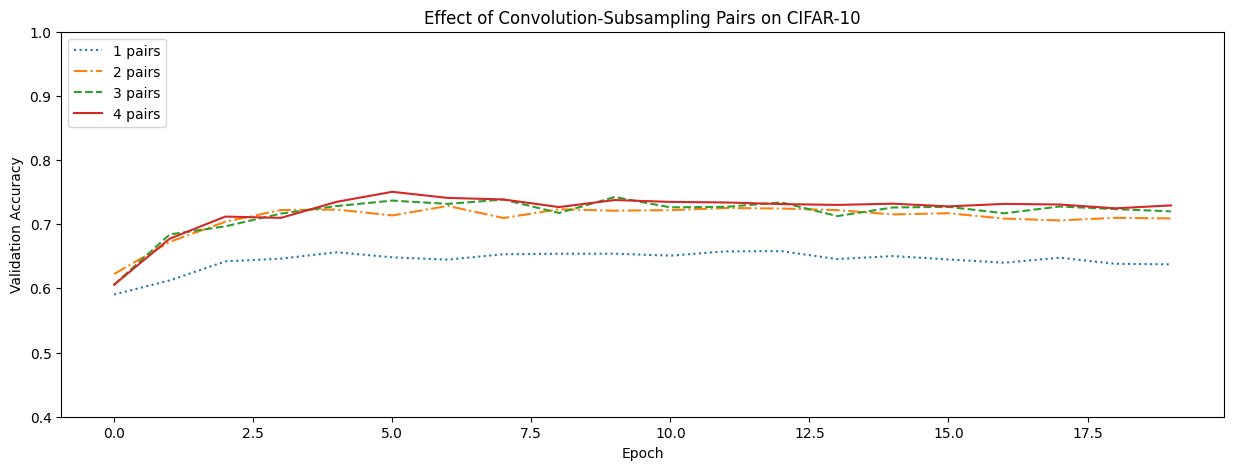

In [9]:
plot_val_acc(val_acc_list, names, styles=styles, title="Effect of Convolution-Subsampling Pairs on CIFAR-10", ylabel="Validation Accuracy", xlabel="Epoch", ylim=(0.4, 1))


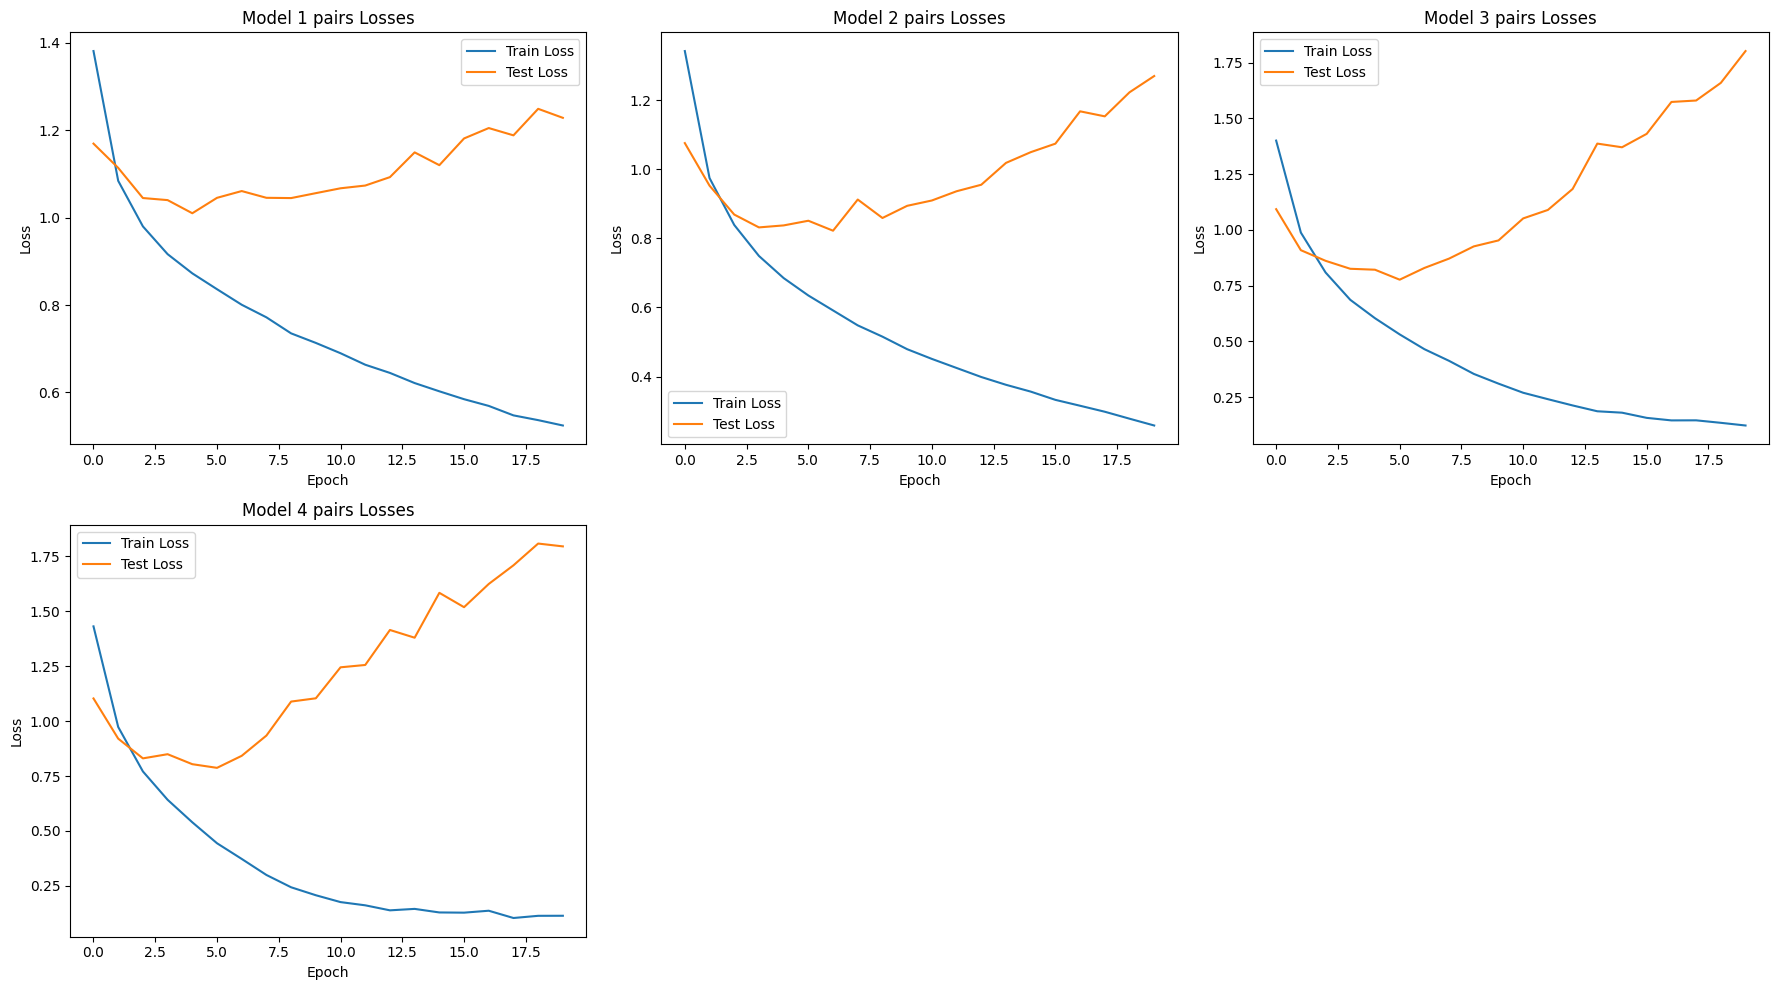

In [10]:
plot_model_losses(train_loss_list, val_loss_list, names)

可以看到，我们使用三次堆叠的结果就可以在当前的状态下得到很好的结果。

### 2. 探究`feature map nums`对模型影响

探究特征图通道深度的影响，组合如下：  

16-32-48，32-48-64，64-96-128

### 模型定义

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, channels_config=None):
        super(SimpleCNN, self).__init__()
        layers = []
        in_channels = 3
        
        # 设置默认的通道数递增配置
        if channels_config is None:
            channels_config = [16, 32, 48]  # 默认配置: 16 -> 32 -> 48
        
        # 根据conv_subsample_pairs和channels_config设置卷积层
        for i in range(3):
            out_channels = channels_config[i]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  
            in_channels = out_channels
        
        layers.append(nn.Flatten())
        
        linear_input_size = in_channels * 16
        layers.append(nn.Linear(linear_input_size, 10))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### 实验过程

In [12]:
# 实验过程
channel_configs = [
    [16, 32, 48],  # 组合1
    [32, 48, 64],  # 组合2
    [64, 96, 128]  # 组合3
]
names = [f"Channels: {cfg}" for cfg in channel_configs]
styles = [':', '-.', '--']

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

In [13]:
# 进行实验
for channel_config in channel_configs:
    print(f"Training with channel config {channel_config}...")
    model = SimpleCNN(channels_config=channel_config).to(device)  # 假设使用3层卷积
    train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, test_loader, epochs=10, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

Training with channel config [16, 32, 48]...
Epoch 1/10, Train Loss: 1.4488, Train Accuracy: 0.4772, Validation Loss: 1.2008, Validation Accuracy: 0.5697
Epoch 3/10, Train Loss: 0.9038, Train Accuracy: 0.6826, Validation Loss: 0.8988, Validation Accuracy: 0.6854
Epoch 5/10, Train Loss: 0.7217, Train Accuracy: 0.7491, Validation Loss: 0.8335, Validation Accuracy: 0.7096
Epoch 7/10, Train Loss: 0.6109, Train Accuracy: 0.7886, Validation Loss: 0.8067, Validation Accuracy: 0.7286
Epoch 9/10, Train Loss: 0.5301, Train Accuracy: 0.8143, Validation Loss: 0.8605, Validation Accuracy: 0.7194
Epoch 10/10, Train Loss: 0.4927, Train Accuracy: 0.8294, Validation Loss: 0.8607, Validation Accuracy: 0.7263
Training with channel config [32, 48, 64]...
Epoch 1/10, Train Loss: 1.3867, Train Accuracy: 0.4993, Validation Loss: 1.1196, Validation Accuracy: 0.6078
Epoch 3/10, Train Loss: 0.8048, Train Accuracy: 0.7203, Validation Loss: 0.8600, Validation Accuracy: 0.7054
Epoch 5/10, Train Loss: 0.6145, Train

### 实验结果

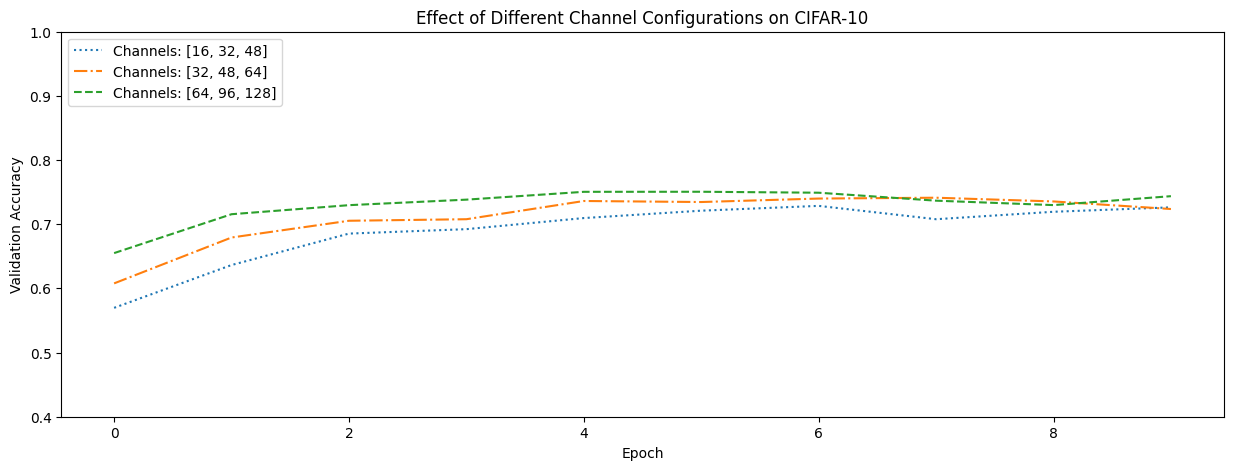

In [14]:
# 绘制验证精度图
plot_val_acc(val_acc_list, names, styles=styles, title="Effect of Different Channel Configurations on CIFAR-10", ylabel="Validation Accuracy", xlabel="Epoch", ylim=(0.4, 1))

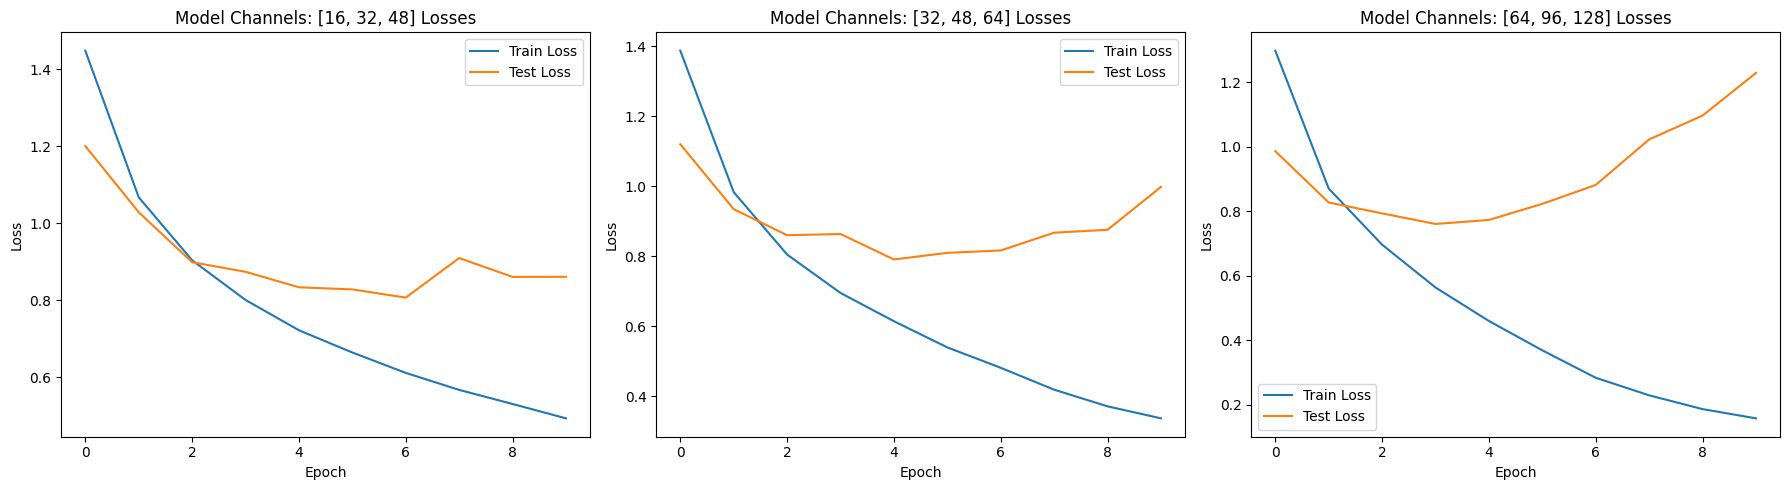

In [15]:
# 绘制训练和验证损失图
plot_model_losses(train_loss_list, val_loss_list, names)

可以看出，feature map nums对模型有一定的影响，我们选择64-96-128，即最大的。

### 3. 探究`dense layer`对模型影响

### 模型定义

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self, dense_size=None):
        super(SimpleCNN, self).__init__()
        layers = []
        in_channels = 3
        
        # 固定的通道数配置：[64, 96, 128]
        channels_config = [64, 96, 128]
        
        # 根据固定的通道配置设置卷积层
        for i in range(3):
            out_channels = channels_config[i]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  
            in_channels = out_channels
        
        # Flatten卷积后的输出
        layers.append(nn.Flatten())
        
        # 固定Dense层的配置，dense_size从0-32-64-128-256到1024
        if dense_size is None:
            dense_size = 32  # 默认配置为32
        
        layers.append(nn.Linear(in_channels * 16, dense_size))  # 16是经过池化后的每个特征图的大小
        layers.append(nn.ReLU())
        
        # 最后是10个分类
        layers.append(nn.Linear(dense_size, 10))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


### 实验过程

In [17]:
dense_sizes = [32, 64, 128, 256, 1024]  # Dense层的尺寸变化配置
names = [f"Dense: {size}" for size in dense_sizes]
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

In [18]:
# 进行实验
for dense_size in dense_sizes:
    print(f"Training with dense size {dense_size}...")
    model = SimpleCNN(dense_size=dense_size).to(device)
    train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, test_loader, epochs=10, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)



Training with dense size 32...
Epoch 1/10, Train Loss: 1.4409, Train Accuracy: 0.4744, Validation Loss: 1.1254, Validation Accuracy: 0.6013
Epoch 3/10, Train Loss: 0.7679, Train Accuracy: 0.7322, Validation Loss: 0.8364, Validation Accuracy: 0.7098
Epoch 5/10, Train Loss: 0.5414, Train Accuracy: 0.8115, Validation Loss: 0.7561, Validation Accuracy: 0.7488
Epoch 7/10, Train Loss: 0.3735, Train Accuracy: 0.8684, Validation Loss: 0.8341, Validation Accuracy: 0.7441
Epoch 9/10, Train Loss: 0.2532, Train Accuracy: 0.9111, Validation Loss: 1.0066, Validation Accuracy: 0.7395
Epoch 10/10, Train Loss: 0.2144, Train Accuracy: 0.9248, Validation Loss: 1.0987, Validation Accuracy: 0.7449
Training with dense size 64...
Epoch 1/10, Train Loss: 1.3872, Train Accuracy: 0.4979, Validation Loss: 1.0646, Validation Accuracy: 0.6220
Epoch 3/10, Train Loss: 0.7280, Train Accuracy: 0.7463, Validation Loss: 0.8746, Validation Accuracy: 0.7001
Epoch 5/10, Train Loss: 0.4925, Train Accuracy: 0.8269, Validatio

### 实验结果

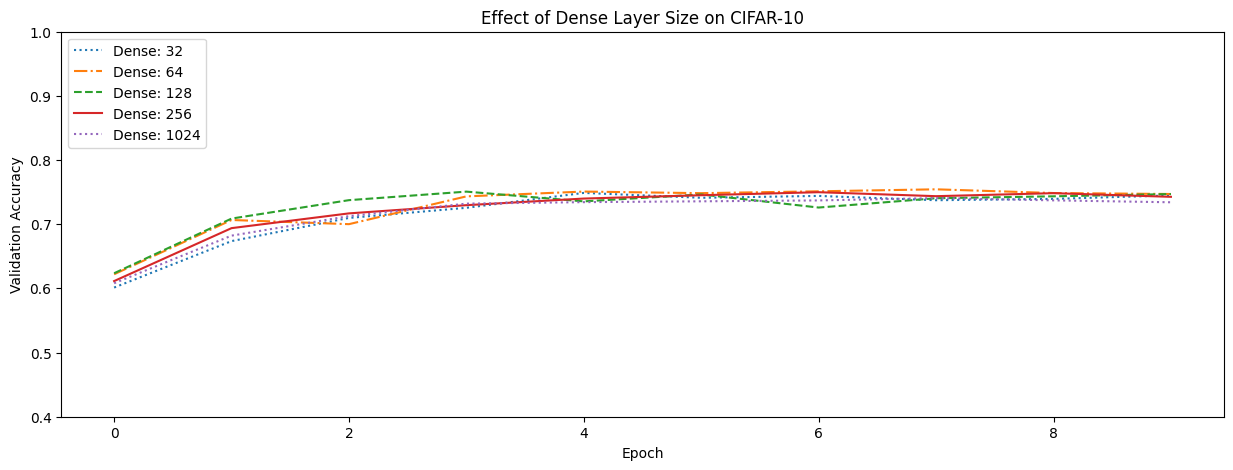

In [19]:
# 绘制验证精度图
plot_val_acc(val_acc_list, names, styles=styles, title="Effect of Dense Layer Size on CIFAR-10", ylabel="Validation Accuracy", xlabel="Epoch", ylim=(0.4, 1))

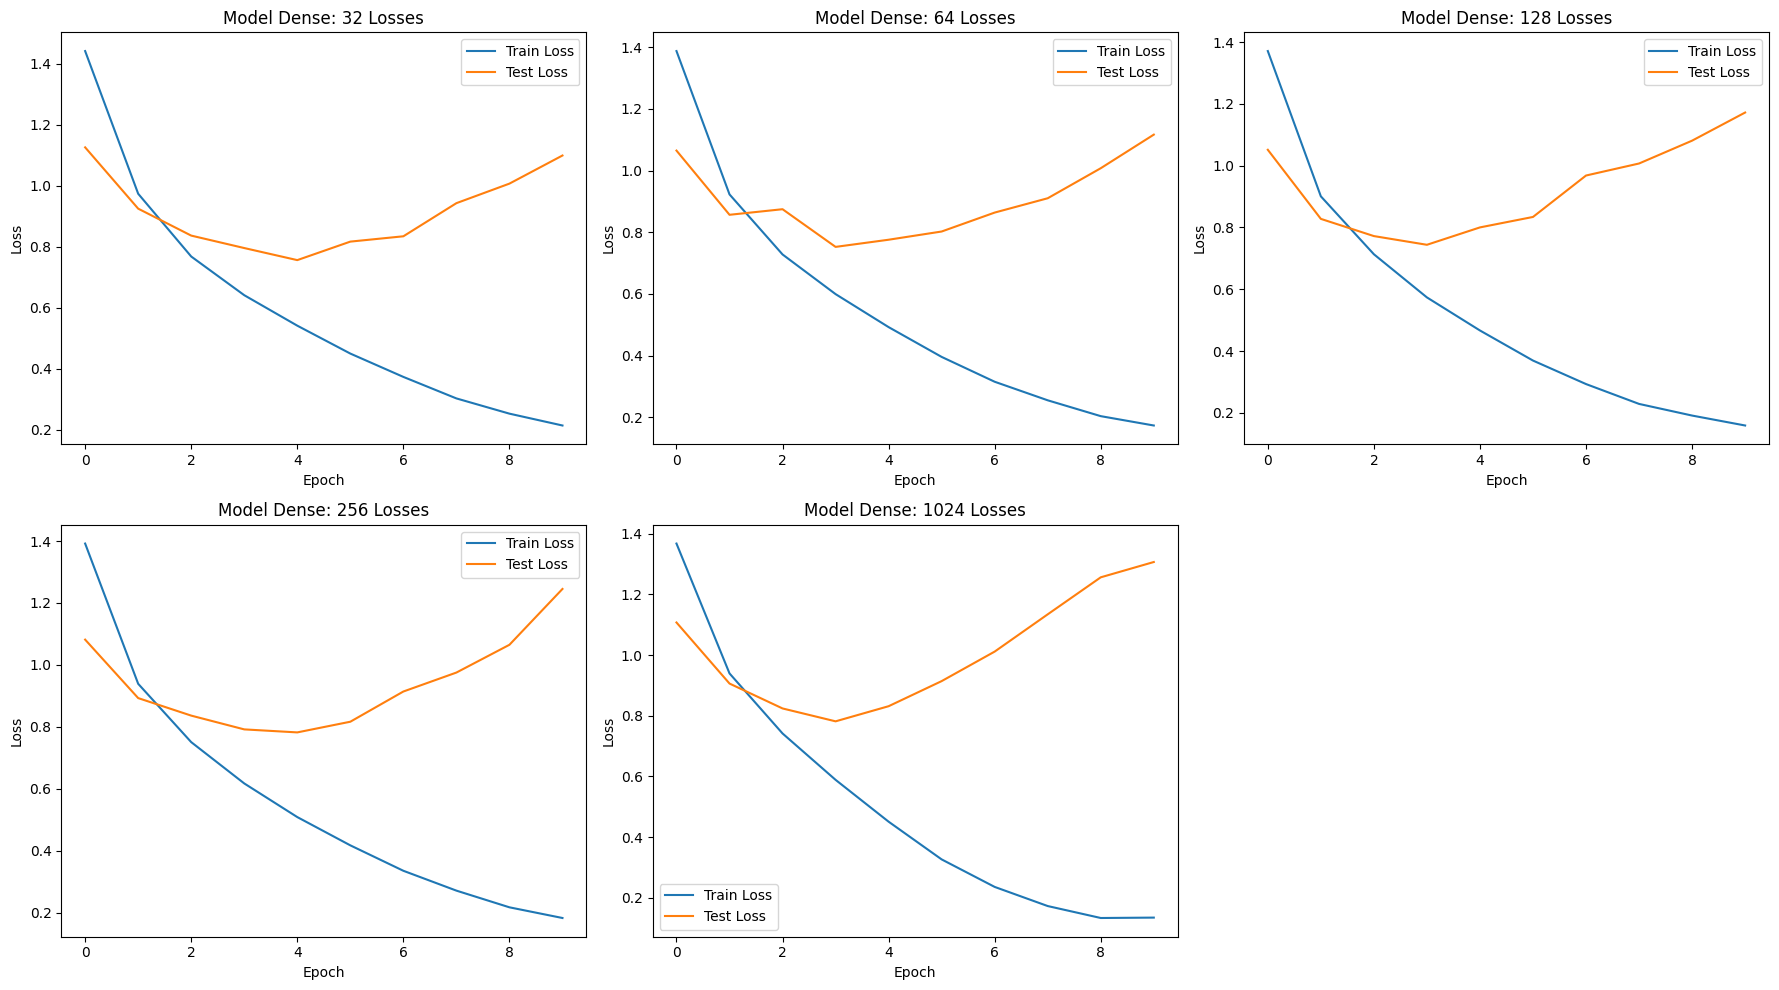

In [20]:
# 绘制训练和验证损失图
plot_model_losses(train_loss_list, val_loss_list, names)

### 4. 探究`How much dropout`对模型影响

### 模型定义

In [21]:
class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate=None):
        super(SimpleCNN, self).__init__()
        layers = []
        in_channels = 3
        
        # 固定的通道数配置：[64, 96, 128]
        channels_config = [64, 96, 128]
        
        # 根据固定的通道配置设置卷积层
        for i in range(3):
            out_channels = channels_config[i]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  
            in_channels = out_channels
        
        # Flatten卷积后的输出
        layers.append(nn.Flatten())
        
        # 固定Dense层的配置：256
        layers.append(nn.Linear(in_channels * 16, 256))  # 16是经过池化后的每个特征图的大小
        layers.append(nn.ReLU())
        
        # 如果指定了Dropout率，则添加Dropout层
        if dropout_rate is not None:
            layers.append(nn.Dropout(dropout_rate))
        
        # 最后是10个分类
        layers.append(nn.Linear(256, 10))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### 实验过程

In [22]:
# 实验过程
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]  # Dropout层的递增配置
names = [f"Dropout: {rate}" for rate in dropout_rates]
styles = [':', '-.', '--', '-', ':']

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

# 进行实验
for dropout_rate in dropout_rates:
    print(f"Training with dropout rate {dropout_rate}...")
    model = SimpleCNN(dropout_rate=dropout_rate).to(device)
    train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, test_loader, epochs=10, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)


Training with dropout rate 0.1...
Epoch 1/10, Train Loss: 1.3614, Train Accuracy: 0.5069, Validation Loss: 1.0579, Validation Accuracy: 0.6291
Epoch 3/10, Train Loss: 0.7117, Train Accuracy: 0.7520, Validation Loss: 0.8121, Validation Accuracy: 0.7270
Epoch 5/10, Train Loss: 0.4681, Train Accuracy: 0.8345, Validation Loss: 0.7630, Validation Accuracy: 0.7473
Epoch 7/10, Train Loss: 0.3068, Train Accuracy: 0.8906, Validation Loss: 0.8251, Validation Accuracy: 0.7595
Epoch 9/10, Train Loss: 0.2104, Train Accuracy: 0.9247, Validation Loss: 1.0436, Validation Accuracy: 0.7537
Epoch 10/10, Train Loss: 0.1781, Train Accuracy: 0.9373, Validation Loss: 1.1021, Validation Accuracy: 0.7547
Training with dropout rate 0.2...
Epoch 1/10, Train Loss: 1.4083, Train Accuracy: 0.4889, Validation Loss: 1.1035, Validation Accuracy: 0.6073
Epoch 3/10, Train Loss: 0.7703, Train Accuracy: 0.7331, Validation Loss: 0.7829, Validation Accuracy: 0.7308
Epoch 5/10, Train Loss: 0.5409, Train Accuracy: 0.8111, Val

### 实验结果

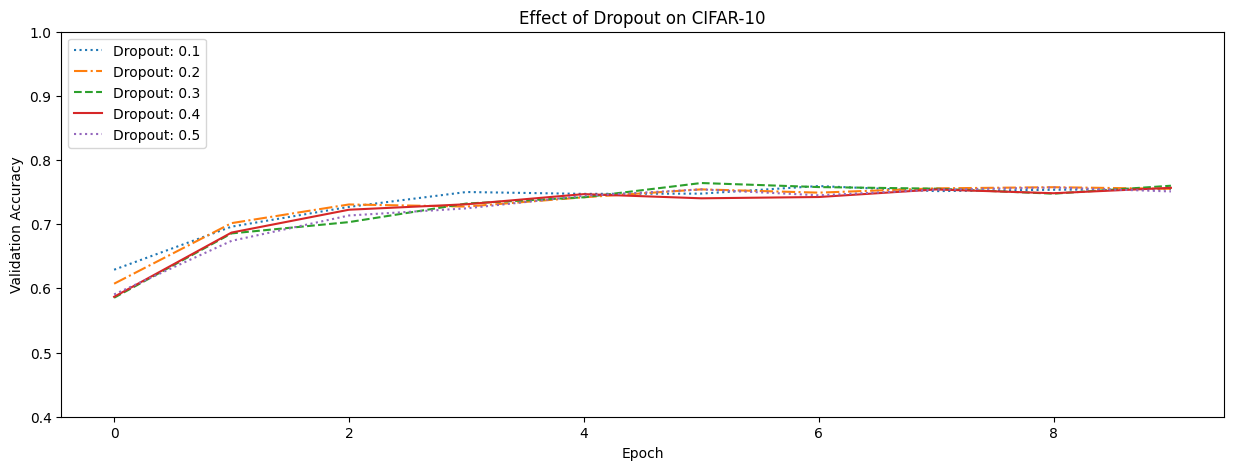

In [23]:
# 绘制验证精度图
plot_val_acc(val_acc_list, names, styles=styles, title="Effect of Dropout on CIFAR-10", ylabel="Validation Accuracy", xlabel="Epoch", ylim=(0.4, 1))

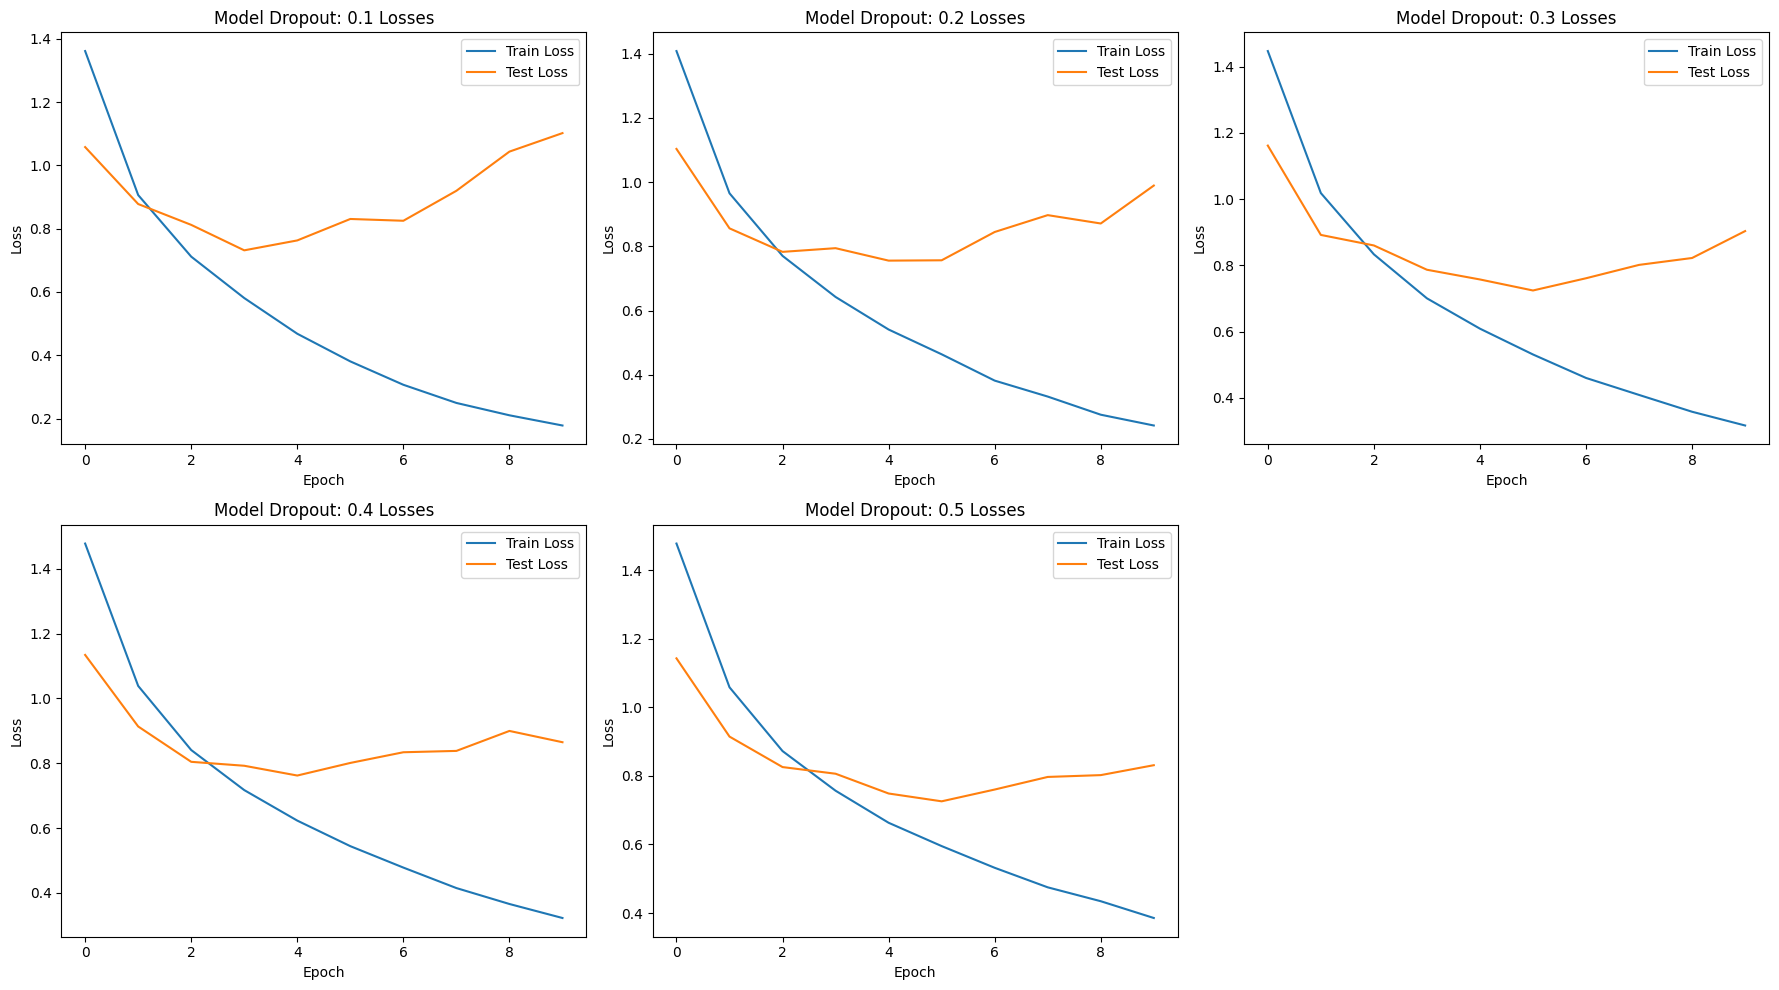

In [24]:
# 绘制训练和验证损失图
plot_model_losses(train_loss_list, val_loss_list, names)

### 5. 加入`Augmentation`对模型影响

## 数据增强

In [25]:
# 强力的数据增强组合，只应用于训练集
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转，保持不变
    transforms.RandomRotation(5),  # 随机旋转角度减小，从15度减少到5度
    transforms.RandomResizedCrop(32, scale=(0.9, 1.0)),  # 随机裁剪，缩放范围减小（不小于90%）
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # 随机调整颜色幅度减小
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化
])

# 仅进行标准化的转换，应用于测试集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化
])

# 加载CIFAR-10数据集
train_dataset_aug = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### 模型定义

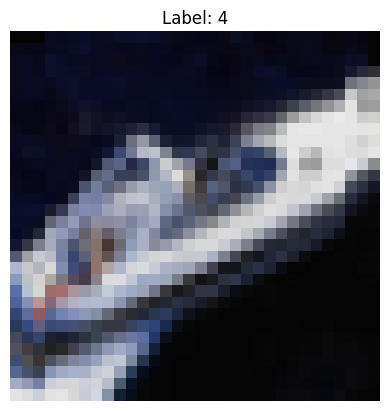

In [26]:
for images, labels in train_loader_aug:
    # 选择第一张图像
    image = images[2]

    # 将图像从Tensor格式转换为NumPy格式
    image = image.numpy().transpose((1, 2, 0))  # 由(3, 32, 32) -> (32, 32, 3)
    image = image * 0.5 + 0.5  # 反标准化，将像素值从[-1, 1]映射回[0, 1]

    # 显示图像
    plt.imshow(image)
    plt.title(f"Label: {labels[0].item()}")
    plt.axis('off')  # 不显示坐标轴
    plt.show()
    break  # 只显示一个批次中的第一张图像

In [27]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        layers = []
        in_channels = 3
        
        # 固定的通道数配置：[64, 96, 128]
        channels_config = [64, 96, 128]
        
        # 根据固定的通道配置设置卷积层
        for i in range(3):
            out_channels = channels_config[i]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  
            in_channels = out_channels
        
        # Flatten卷积后的输出
        layers.append(nn.Flatten())
        
        # 固定Dense层的配置：256
        layers.append(nn.Linear(in_channels * 16, 256))  # 16是经过池化后的每个特征图的大小
        layers.append(nn.ReLU())
        
        
        layers.append(nn.Dropout(0.5))
        
        # 最后是10个分类
        layers.append(nn.Linear(256, 10))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### 实验过程

In [28]:
model = SimpleCNN().to(device)
# 进行训练
train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader_aug, test_loader, epochs=30, device=device)

Epoch 1/30, Train Loss: 1.5701, Train Accuracy: 0.4244, Validation Loss: 1.2412, Validation Accuracy: 0.5524
Epoch 3/30, Train Loss: 1.0553, Train Accuracy: 0.6336, Validation Loss: 0.9081, Validation Accuracy: 0.6813
Epoch 5/30, Train Loss: 0.8995, Train Accuracy: 0.6918, Validation Loss: 0.8107, Validation Accuracy: 0.7278
Epoch 7/30, Train Loss: 0.8181, Train Accuracy: 0.7182, Validation Loss: 0.7947, Validation Accuracy: 0.7265
Epoch 9/30, Train Loss: 0.7621, Train Accuracy: 0.7373, Validation Loss: 0.7275, Validation Accuracy: 0.7526
Epoch 11/30, Train Loss: 0.7229, Train Accuracy: 0.7518, Validation Loss: 0.7201, Validation Accuracy: 0.7581
Epoch 13/30, Train Loss: 0.6912, Train Accuracy: 0.7632, Validation Loss: 0.6923, Validation Accuracy: 0.7693
Epoch 15/30, Train Loss: 0.6690, Train Accuracy: 0.7724, Validation Loss: 0.6676, Validation Accuracy: 0.7781
Epoch 17/30, Train Loss: 0.6485, Train Accuracy: 0.7784, Validation Loss: 0.6705, Validation Accuracy: 0.7790
Epoch 19/30, Tr

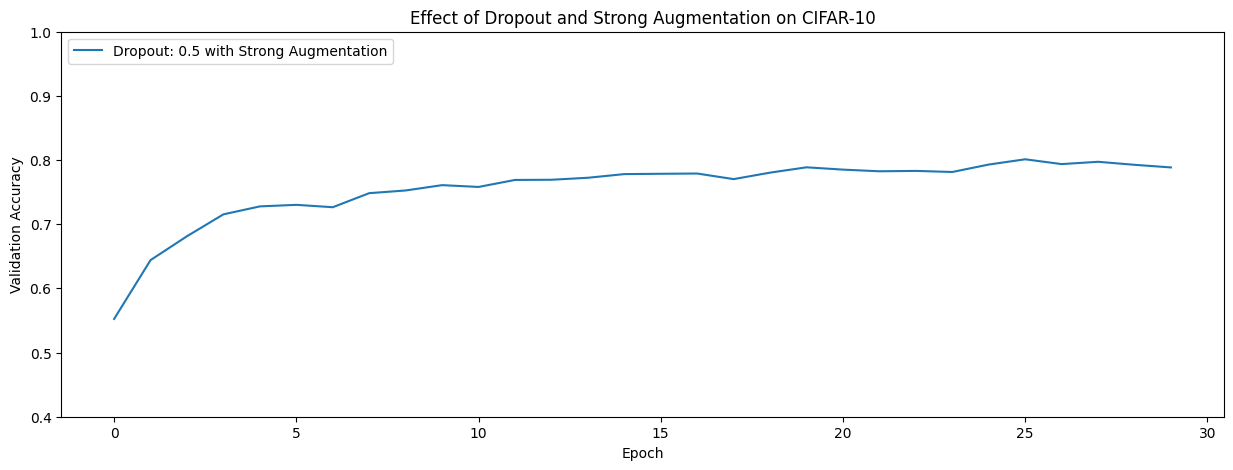

In [29]:
# 绘制验证精度图
plot_val_acc([val_acc], ['Dropout: 0.5 with Strong Augmentation'], styles=['-'], title="Effect of Dropout and Strong Augmentation on CIFAR-10", ylabel="Validation Accuracy", xlabel="Epoch", ylim=(0.4, 1))

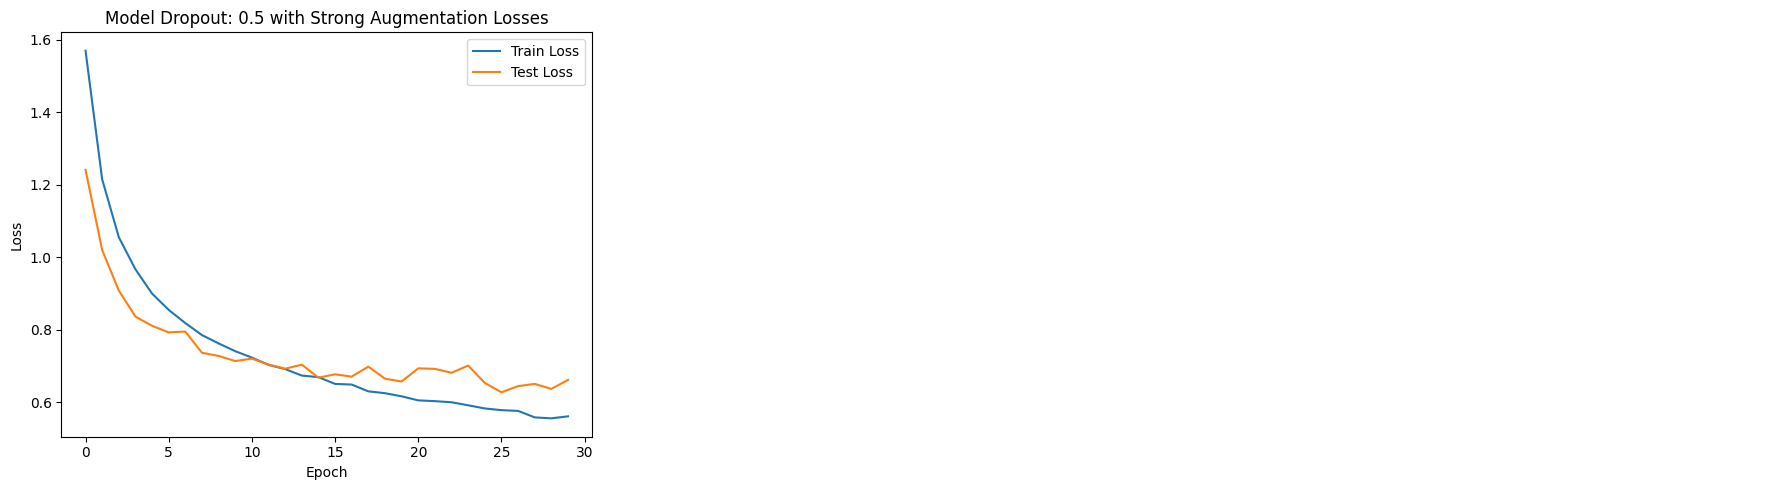

In [30]:
# 绘制训练和验证损失图
plot_model_losses([train_loss], [val_loss], ['Dropout: 0.5 with Strong Augmentation'])

### 实验结果

我们可以看出，加上数据增强之后模型的泛化能力极大提高，上升了5%左右

## 实验总结

我们可以看出，数据增强对模型的泛化能力提升最强，约为5%左右。此外，特征图通道数量的深度对模型的提升也非常大。     
即使我们用了非常小的模型（仅仅三层），用上比较好的调参技巧，也可以在`cifar10`上把把模型训练到80%的准确率。    
通过这次实验，我们组能够很好的理解各种参数对模型的作用。